In [1]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader, Subset
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import AWLoss
from datasets import MaskedUltrasoundDataset2D
from landscape import *


import matplotlib.pyplot as plt
import progressbar
import random
import numpy as np

## CUDA Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)                     
device=set_device("cuda", 0)              

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-80GB!


# MRI Dataset 

In [3]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def resize(x, nc, h, w):
    return torch.nn.functional.interpolate(x.unsqueeze(0).unsqueeze(0), size=(nc, h, w)).squeeze(0).squeeze(0)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x

def create_mask(size, width, spacing):
    assert len(size) == len(width) == len(spacing)
    m = torch.ones(size)
    idxs = []
    for i in range(len(size)):
        wd, sp, s, = width[i], spacing[i], size[i]
        idx = []
        if wd > 0:
            for j in range(int(s / (wd + sp)) + 1):
                idx+= [j*(wd+sp) + k for k in range(wd)]
        else:
            idx += [j for j in range(s)]
        idx = [k for k in idx if k < s]
        idxs.append(torch.tensor(idx))
    idmesh = torch.meshgrid(*idxs)
    m[idmesh] = 0.
    return m


In [4]:
# path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI-sagittal/")
n = 128
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal/")
train_transform = Compose([
                    Resize(n),
                    Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x, "outer")),
                    Lambda(lambda x: scale2range(x, [-1., 1.])),
                    # Normalize([0.09779735654592514], [0.16085614264011383])
                    ])

mask = create_mask((n,n), (0,1), (0,2))

ds = MaskedUltrasoundDataset2D(path, 
                                    mode="mri",
                                    transform=train_transform,
                                    mask=mask,
                                    maxsamples=None)
print(ds, "\n")
# print(ds.info())


{'name': 'MaskedUltrasoundDataset2D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal', 'maxsamples': None, 'transform': Compose(
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
    Lambda()
    Lambda()
    Lambda()
), 'mask': tensor([[0., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.]]), 'mode': 'mri', 'len': 553} 



/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Data split

In [5]:
valid_ratio = 0.3
i = int(len(ds)*valid_ratio)

idxs = np.arange(0, len(ds), 1)
np.random.shuffle(idxs)

train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)

print(len(trainds), len(validds))

388 165


In [6]:
# data = []
# for i in range(len(trainds)):
#     data += list((trainds[i][1].flatten().detach().cpu().numpy()))
# plt.title("Train Dataset Value")
# plt.hist(data)
# plt.show()

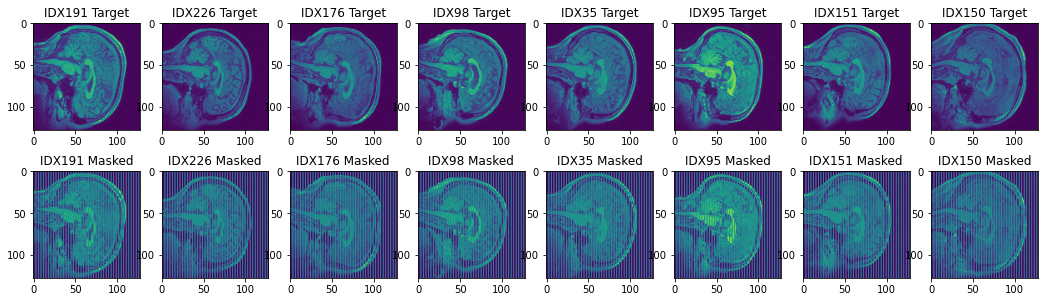

In [7]:
fig, axs = plt.subplots(2,8, figsize=(18, 5))
for i, n in enumerate(np.random.randint(0, len(trainds), size=(axs.shape[1]))):
    tgt = axs[0][i].imshow(trainds[n][1].permute(1,2,0), vmin=-1, vmax=1)
    axs[0][i].set_title("IDX%g Target"%n)
    msk = axs[1][i].imshow(trainds[n][0].permute(1,2,0), vmin=-1, vmax=1)
    axs[1][i].set_title("IDX%g Masked"%n)

# Model 

In [8]:
def make_model(nc=64):
    channels = (16, 32)#, 64)#, 128, 256)
    model =  UNet(
    spatial_dims=2,
    in_channels=nc,
    out_channels=nc,
    channels=channels,
    strides=tuple([2 for i in range(len(channels))]), 
    num_res_units=1,
    act="mish")
    model = nn.DataParallel(model) 
    return model.to(device)
print(make_model())

/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


DataParallel(
  (module): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): Mish()
            )
          )
        )
        (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): SkipConnection(
        (submodule): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.0, inplace=False)
                (A): Mish()
              

# Train and Validate Functions

In [9]:
def train(model, train_loader, optimizer, criterion, device="cpu"):
    """ Trains one epoch, validates with MSE """
    model.train()
    
    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)

        # Backprop and optim step
        loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates model with criterion and MSE"""
    model.eval()

    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

In [10]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    all_train_losses, all_valid_losses, all_train_mse, all_valid_mse = [], [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            train_loss, train_mse = train(model, train_loader, optimizer, loss, device)
            valid_loss, valid_mse = validate(model, valid_loader, loss, device)
            
            all_train_losses.append(train_loss.item())
            all_train_mse.append(train_mse.item())
            all_valid_losses.append(valid_loss.item())
            all_valid_mse.append(valid_mse.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "train_loss": train_loss.item(), "train_mse":train_mse.item(), "valid_loss": valid_loss.item(), "valid_mse":valid_mse.item()}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 10))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(all_train_losses, label="train")
                axs[0].plot(all_valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(all_train_mse, label="train")
                axs[1].plot(all_valid_mse, label="valid")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[1].set_title("MSE")

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.tanh(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx], vmin=-1, vmax=1)
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy(), vmin=-1, vmax=1)
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx], vmin=-1, vmax=1)
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        if "awloss" in str(loss).lower():
                            try:
                                v, T = loss.filters[0], loss.T
                            except:
                                loss_list = [str(l) for l in loss.losses]
                                awloss = loss.losses[loss_list.index("AWLoss()")]
                                v, T = awloss.filters[0], awloss.T
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                        else:
                            pass


            plt.show()

# Training Setup

In [11]:
# Set training static parameters and hyperparameters
nepochs=500                        
learning_rate=1e-2
batch_size=32                                        

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)
valid_loader = DataLoader(validds,
                        batch_size=1000,
                        shuffle=False,
                        num_workers=4)


# Sample for visualisation
x_sample, y_sample = validds[0]

# Train MSE Loss



Training started ...


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.31150856614112854, 'train_mse': 0.31150856614112854, 'valid_loss': 0.19925597310066223, 'valid_mse': 0.19925597310066223}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


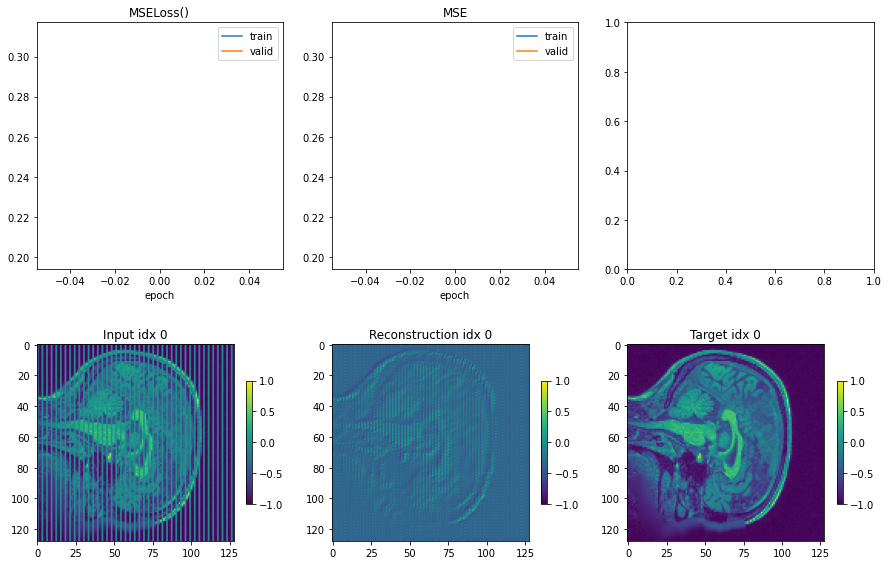

 99% (149 of 150) |##################### | Elapsed Time: 0:06:51 ETA:   0:00:02


 {'epoch': 149, 'train_loss': 0.006028951145708561, 'train_mse': 0.006028951145708561, 'valid_loss': 0.005739211104810238, 'valid_mse': 0.005739211104810238}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


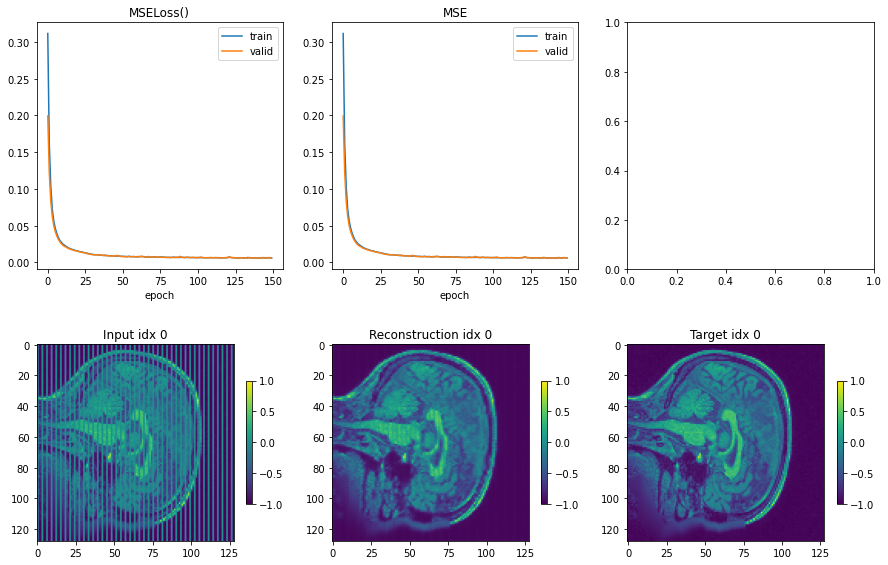

100% (150 of 150) |######################| Elapsed Time: 0:06:51 Time:  0:06:51


In [12]:
msemodel = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(msemodel.parameters(), lr=learning_rate)

mseloss     = nn.MSELoss(reduction="mean")

train_model(msemodel, optimizer, mseloss, train_loader,  valid_loader=valid_loader, nepochs=150, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

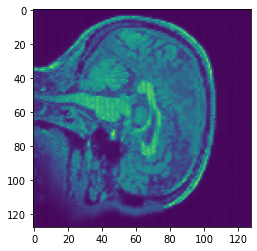

In [13]:
msemodel.eval()
X = x_sample.unsqueeze(0).to(device)
recon = torch.tanh(msemodel(X))[0].detach().cpu()
# recon = scale2range(recon.detach().cpu(), [-1, 1])
plt.imshow(recon[0], vmin=-1, vmax=1)
plt.show()

Angle between x_dir and y_dir: 90.52 °


100% (625 of 625) |######################| Elapsed Time: 0:27:42 Time:  0:27:42


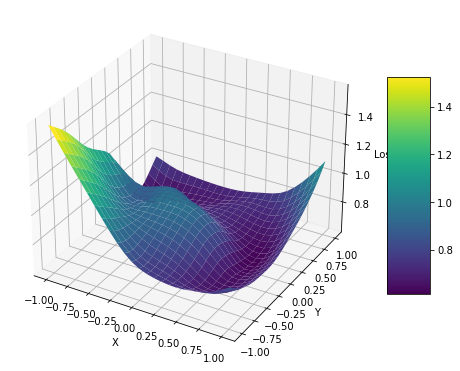

In [ ]:
xx, yy, loss_landscape = visualise_landscape(msemodel, train_loader, mseloss, device=device, xmin=-1, xmax=1, ymin=-1, ymax=1)

# Train AWLoss



Training started ...


[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
N/A% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.6484735012054443, 'train_mse': 0.42032870650291443, 'valid_loss': 0.6019279956817627, 'valid_mse': 0.35268473625183105}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


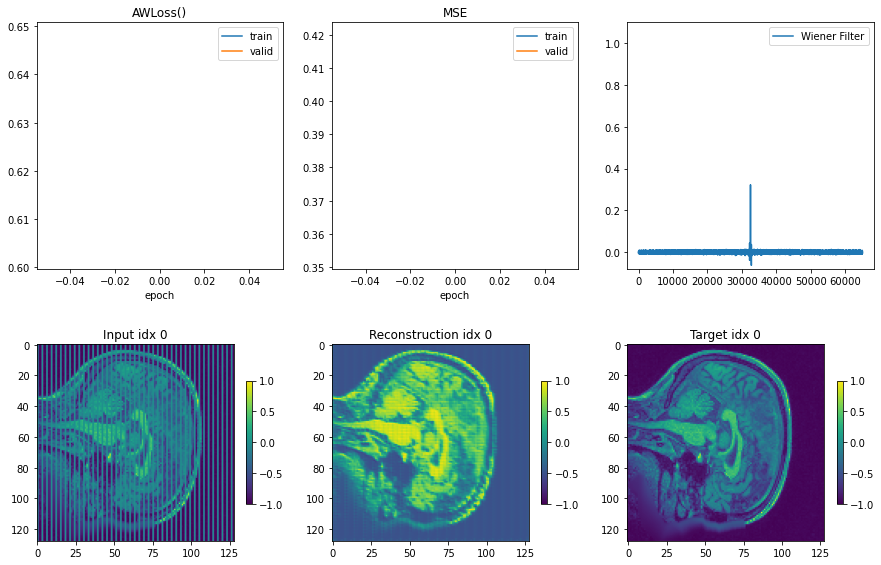

 10% (50 of 500) |##                     | Elapsed Time: 0:03:28 ETA:   0:32:32


 {'epoch': 50, 'train_loss': 0.49737340211868286, 'train_mse': 0.10408875346183777, 'valid_loss': 0.5131934881210327, 'valid_mse': 0.10862419754266739}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


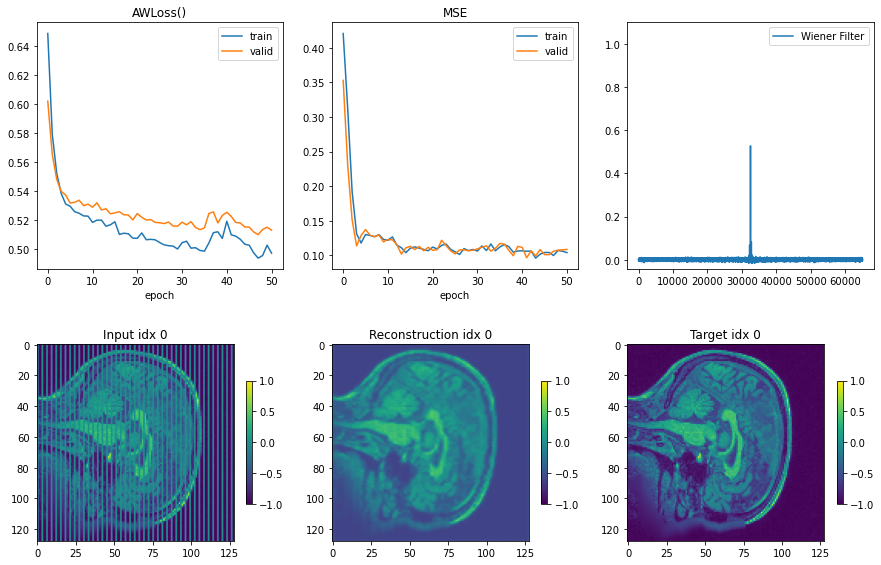

 20% (100 of 500) |####                  | Elapsed Time: 0:06:55 ETA:   0:29:56


 {'epoch': 100, 'train_loss': 0.4916883111000061, 'train_mse': 0.11067676544189453, 'valid_loss': 0.510597825050354, 'valid_mse': 0.11835985630750656}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


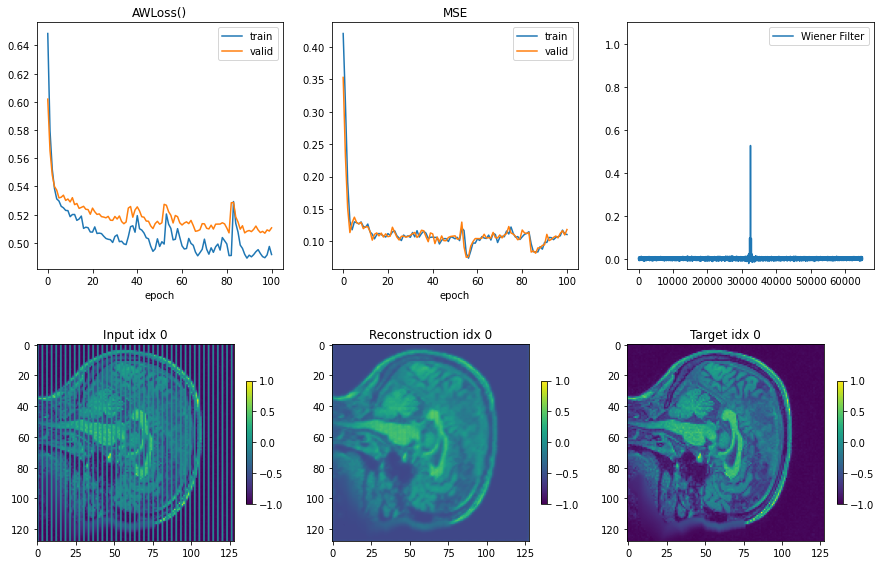

 30% (150 of 500) |######                | Elapsed Time: 0:10:20 ETA:   0:24:23


 {'epoch': 150, 'train_loss': 0.48492535948753357, 'train_mse': 0.10350362211465836, 'valid_loss': 0.5023995041847229, 'valid_mse': 0.10854339599609375}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


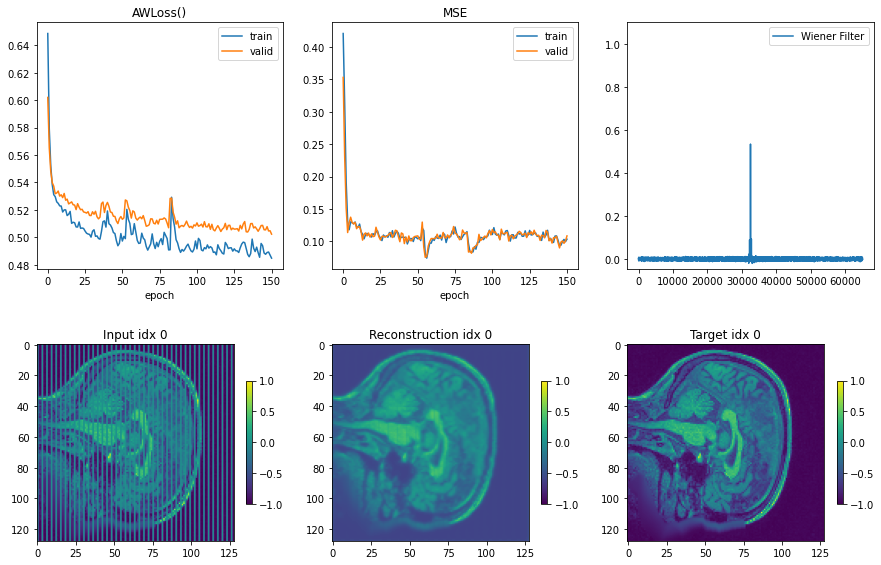

 40% (200 of 500) |########              | Elapsed Time: 0:13:44 ETA:   0:19:40


 {'epoch': 200, 'train_loss': 0.49730008840560913, 'train_mse': 0.12067556381225586, 'valid_loss': 0.5112422704696655, 'valid_mse': 0.11455002427101135}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


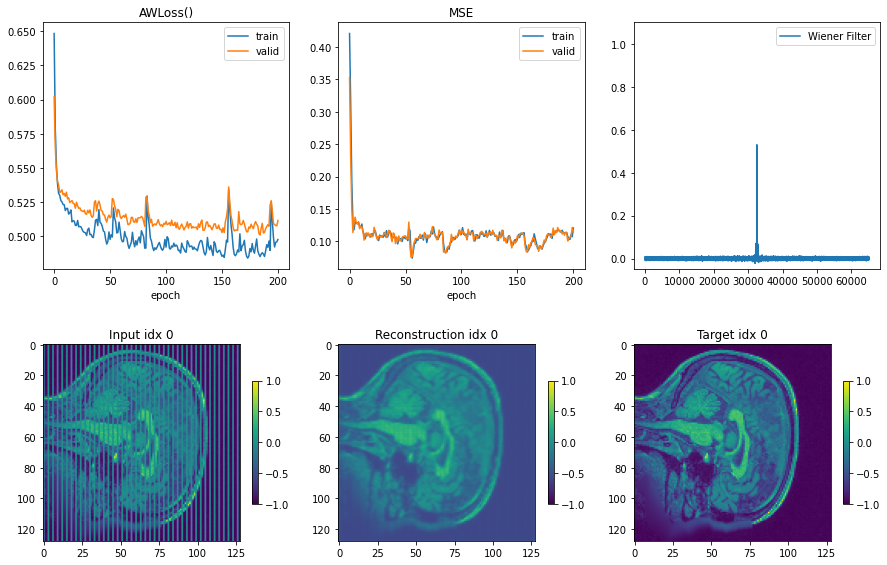

 50% (250 of 500) |###########           | Elapsed Time: 0:17:07 ETA:   0:17:02


 {'epoch': 250, 'train_loss': 0.48659369349479675, 'train_mse': 0.11293414980173111, 'valid_loss': 0.5021647810935974, 'valid_mse': 0.11362753063440323}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


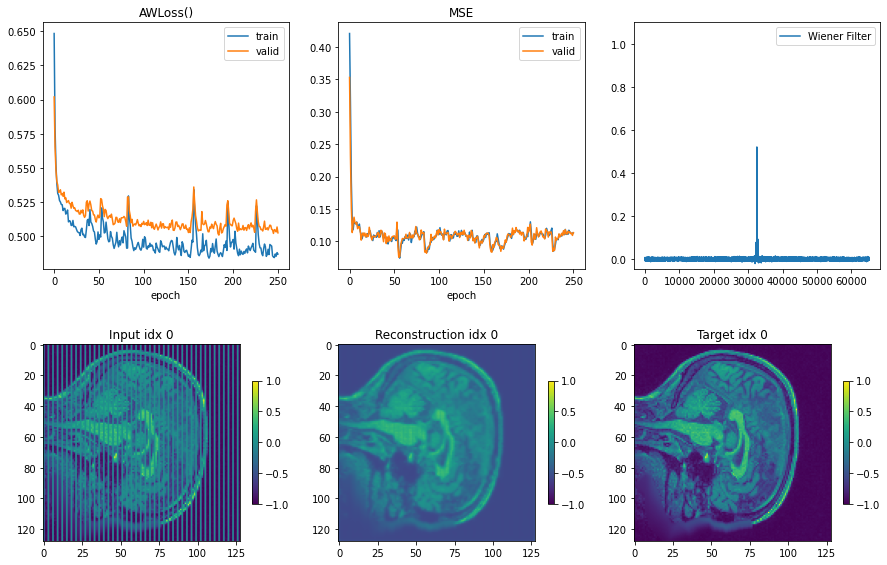

 60% (300 of 500) |#############         | Elapsed Time: 0:20:29 ETA:   0:13:27


 {'epoch': 300, 'train_loss': 0.491538941860199, 'train_mse': 0.109473317861557, 'valid_loss': 0.5040244460105896, 'valid_mse': 0.1154642105102539}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


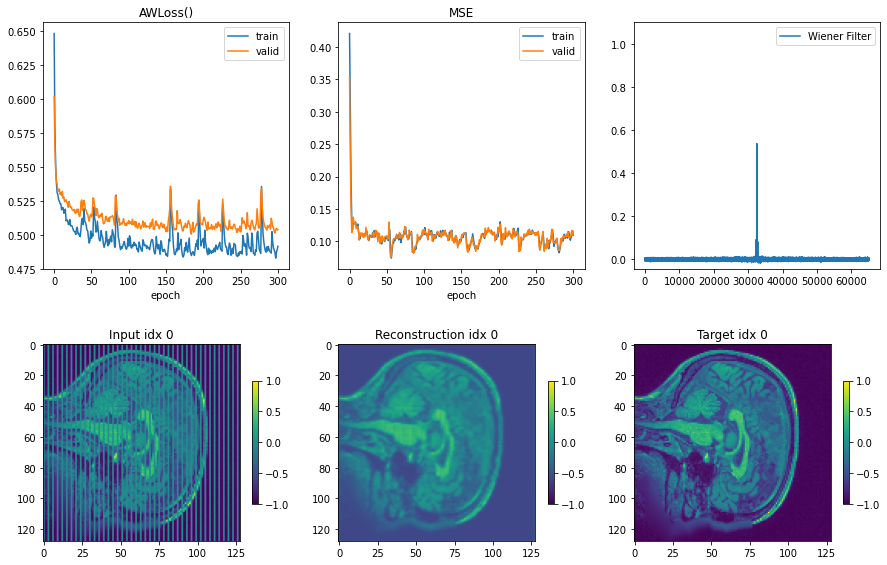

 70% (350 of 500) |###############       | Elapsed Time: 0:23:51 ETA:   0:10:23


 {'epoch': 350, 'train_loss': 0.49535083770751953, 'train_mse': 0.10421956330537796, 'valid_loss': 0.5043197274208069, 'valid_mse': 0.1045582965016365}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


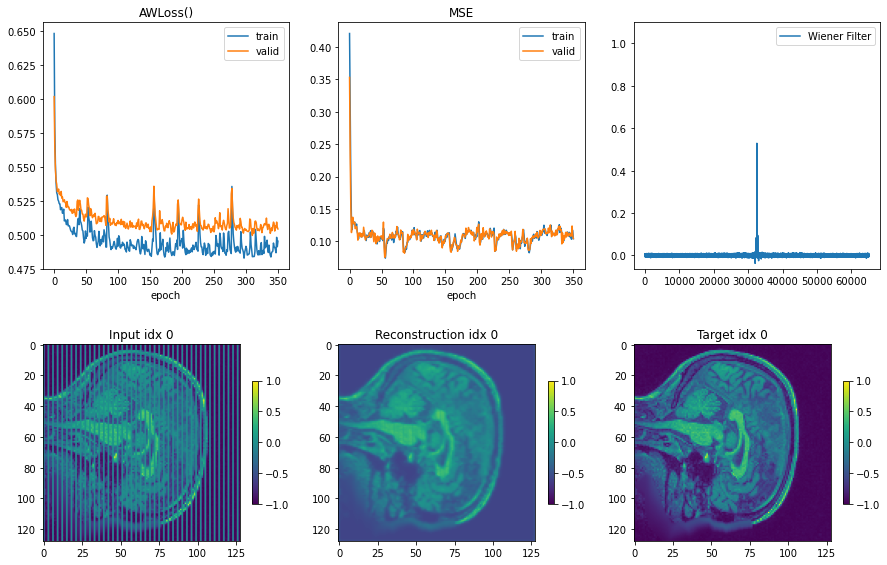

 80% (400 of 500) |#################     | Elapsed Time: 0:27:12 ETA:   0:06:44


 {'epoch': 400, 'train_loss': 0.4896601438522339, 'train_mse': 0.09908944368362427, 'valid_loss': 0.5023593902587891, 'valid_mse': 0.10376320779323578}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


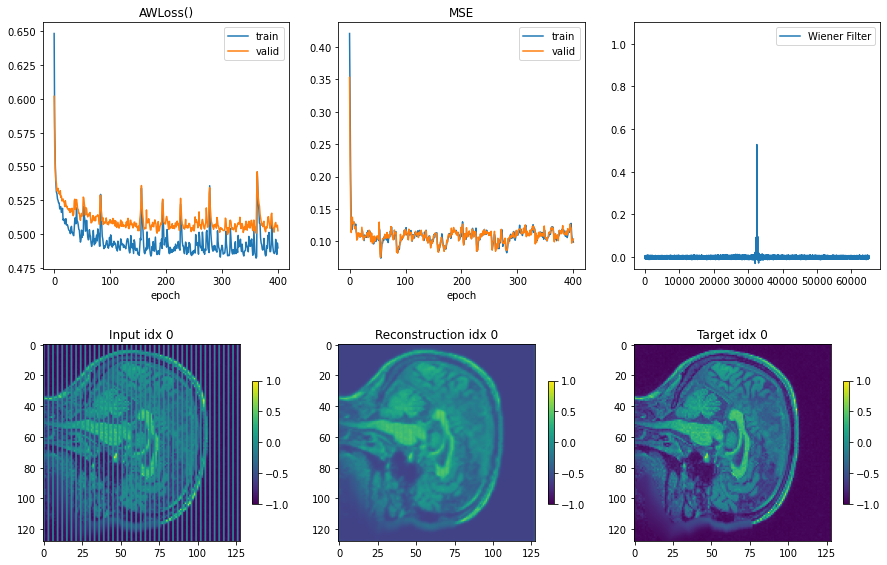

 90% (450 of 500) |###################   | Elapsed Time: 0:30:34 ETA:   0:03:18


 {'epoch': 450, 'train_loss': 0.4887198209762573, 'train_mse': 0.10544915497303009, 'valid_loss': 0.5125157237052917, 'valid_mse': 0.09449534863233566}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


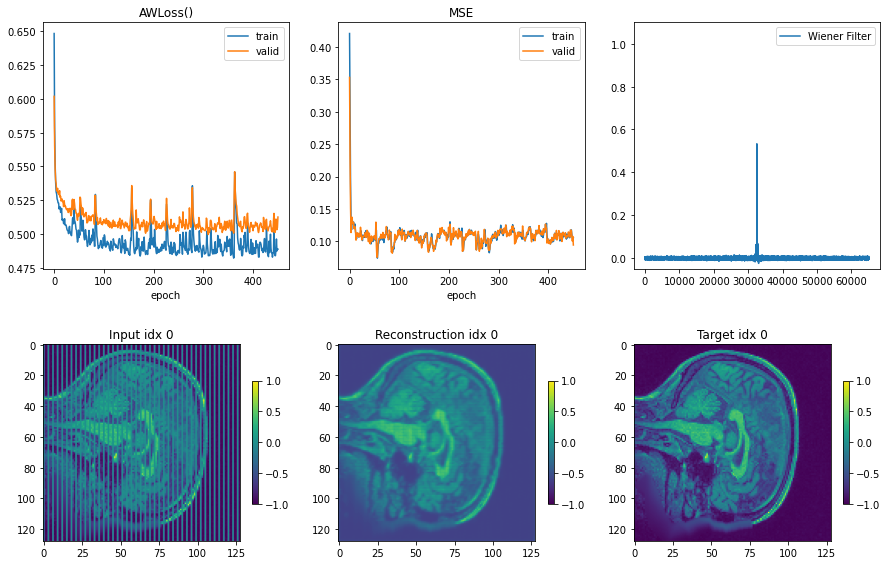

 99% (499 of 500) |##################### | Elapsed Time: 0:33:51 ETA:   0:00:03


 {'epoch': 499, 'train_loss': 0.48373809456825256, 'train_mse': 0.10157980769872665, 'valid_loss': 0.5011880397796631, 'valid_mse': 0.10561585426330566}
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
 argidx T, v:  32512 32512


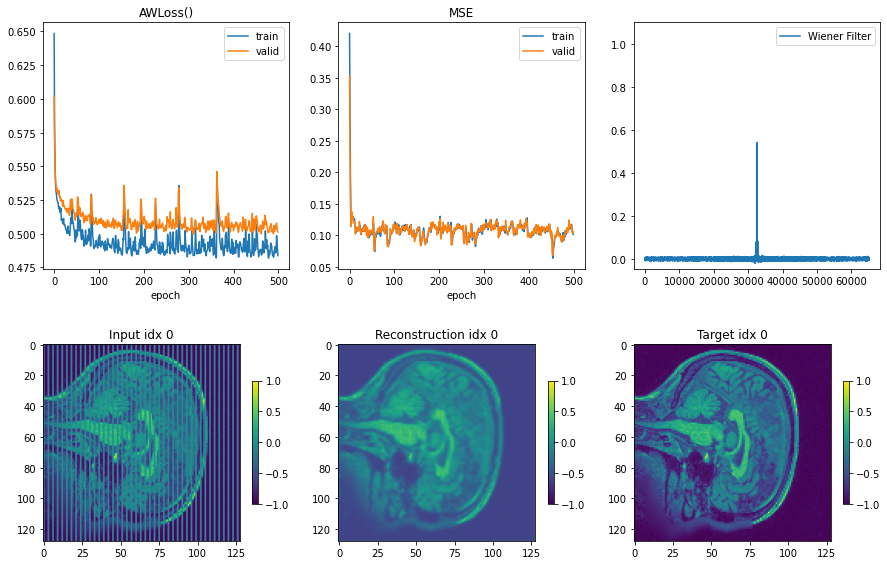

100% (500 of 500) |######################| Elapsed Time: 0:33:52 Time:  0:33:52


In [14]:
awmodel = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(awmodel.parameters(), lr=learning_rate, weight_decay=1e-3)

awloss     = AWLoss(filter_dim=2, method="fft", reduction="mean", store_filters="norm", epsilon=3e-15)

train_model(awmodel, optimizer, awloss, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=50, sample_input=x_sample, sample_target=y_sample, device=device)

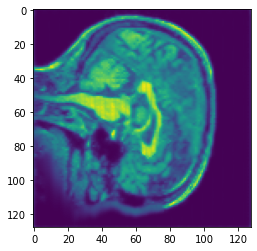

In [16]:
awmodel.eval()
X = x_sample.unsqueeze(0).to(device)
recon = torch.tanh(awmodel(X))[0].detach().cpu()
recon = scale2range(recon, [-1, 1])
plt.imshow(recon[0])
plt.show()

In [ ]:
xx, yy, loss_landscape = visualise_landscape(awmodel, train_loader, awloss, device=device, xmin=-1, xmax=1, ymin=-1, ymax=1)

# Train AWLoss + MSE

In [ ]:
from math import log, floor
class JointLoss(nn.Module):
    def __init__(self, losses, weights, norm=False):
        super(JointLoss, self).__init__()
        self.losses = losses
        self.weights = weights
        self.norm = norm

    def __str__(self):
        name = ""
        for l , w in zip(self.losses, self.weights):
            name += "{}(w={:.1E}) ".format(str(l)[:-2], w)
        return name[:-1]

    def scale(self, x):
        if self.norm:
            return x / 10**floor(log(x, 10))
        else:
            return x

    def forward(self, x, y):
        total_loss = 0.
        for l, w in zip(self.losses, self.weights):
            total_loss += w * self.scale(l(x, y))
        return total_loss

In [ ]:
combmodel = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(combmodel.parameters(), lr=learning_rate)

awloss      = AWLoss(filter_dim=2, method="fft", reduction="mean", std=3e-4, store_filters="norm", epsilon=3e-15)
mseloss     = nn.MSELoss(reduction="mean")
combined    = JointLoss((awloss, mseloss), (1., 0.5), norm=True)

train_model(combmodel, optimizer, combined, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=50, sample_input=x_sample, sample_target=y_sample, device=device)



Training started ...


100% (500 of 500) |######################| Elapsed Time: 0:00:00 ETA:  00:00:00


RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cuda:1

In [ ]:
xx, yy, loss_landscape = visualise_landscape(combmodel, train_loader, combined, device=device, xmin=-1, xmax=1, ymin=-1, ymax=1)